# Importing Packages Needed

In [1]:
import numpy as np

In [2]:
import scipy as sp

In [3]:
import matplotlib.pyplot as py

In [4]:
from scipy.optimize import curve_fit

In [5]:
from scipy.signal import find_peaks

In [6]:
import collections as col

In [7]:
import statistics

# Definition of Named Tuples

In [8]:
component = col.namedtuple('component','phase intensity')

In [9]:
ind_component = col.namedtuple('component','phase intensity width')

In [10]:
pulse_component = col.namedtuple('pulse_component','frequency comp1 comp2 errors')

In [11]:
component_separation = col.namedtuple('component_separation','frequency separation')

# Definition of Functions

Gaussian Fitting Functions:

In [12]:
def gauss(x,cen,sd,amp):
    return amp*np.exp(-(x-cen)**2/2/sd**2)

def twogauss(x,cen1,sd1,amp1,cen2,sd2,amp2):
    return gauss(x,cen1,sd1,amp1)+gauss(x,cen2,sd2,amp2)

def threegauss(x,cen1,sd1,amp1,cen2,sd2,amp2,cen3,sd3,amp3):
    return gauss(x,cen1,sd1,amp1)+gauss(x,cen2,sd2,amp2)+gauss(x,cen3,sd3,amp3)

In [13]:
def fitting_parameters(x,y,expected):
    params,cov=curve_fit(threegauss,x,y,expected, bounds=([0,0,0,0,0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]))
    sigma=np.sqrt(np.diag(cov))
    return params, sigma

def gauss_fit(x,params):
    return threegauss(x,*params)

Finding Peak of Fittings Function

In [14]:
def which_peaks(params, peakpos, sigma):
    errors=[]
    if abs(peakpos[0]-params[0])<abs(peakpos[0]-params[1]) and abs(peakpos[0]-params[0])<abs(peakpos[0]-params[2]):
        errors.extend((sigma[0],sigma[1],sigma[2]))
    elif abs(peakpos[0]-params[1])<abs(peakpos[0]-params[0]) and abs(peakpos[0]-params[1])<abs(peakpos[0]-params[2]):
        errors.extend((sigma[3],sigma[4],sigma[5]))
    elif abs(peakpos[0]-params[2])<abs(peakpos[0]-params[0]) and abs(peakpos[0]-params[2])<abs(peakpos[0]-params[1]):
        errors.extend((sigma[6],sigma[7],sigma[8]))
        
    if abs(peakpos[1]-params[0])<abs(peakpos[1]-params[1]) and abs(peakpos[1]-params[0])<abs(peakpos[1]-params[2]):
        errors.extend((sigma[0],sigma[1],sigma[2]))
    elif abs(peakpos[1]-params[1])<abs(peakpos[1]-params[0]) and abs(peakpos[1]-params[1])<abs(peakpos[1]-params[2]):
        errors.extend((sigma[3],sigma[4],sigma[5]))
    elif abs(peakpos[1]-params[2])<abs(peakpos[1]-params[0]) and abs(peakpos[1]-params[2])<abs(peakpos[1]-params[1]):
        errors.extend((sigma[6],sigma[7],sigma[8]))
        
    return errors

In [15]:
def gauss_peaks_gmrt(params,fit, nofreqband, freqband, sigma):
    status='starting'
      
    #Find the peaks of the fit
    i=3
    peakpos = find_peaks(fit, prominence=i, distance=50, height=i)[0]

    #If there aren't two peaks, adjust prominence to find two peaks
    while len(peakpos) !=2 and i>=0.5:
        if len(peakpos) < 2:
            i=i-0.5
            peakpos = find_peaks(fit, prominence=i, distance=50, height=1)[0]

        elif len(peakpos) > 2:
            i=i+0.5
            peakpos = find_peaks(fit, prominence=i, distance=50, height=2)[0]

    #Ensure peaks are ordered correctly
    if len(peakpos) == 2:
        status='pending'
        sigma=which_peaks(params,peakpos,sigma)
        
        if peakpos[0]>=300 and peakpos[0]<=600 and peakpos[1]>=600 and peakpos[1]<=900:
            status='complete'
        elif peakpos[1]>=300 and peakpos[1]<=600 and peakpos[0]>=600 and peakpos[0]<=900:
            temp=peakpos[1]
            peakpos[1]=peakpos[0]
            peakpos[0]=temp
            
            temp2=sigma[0:3]
            del sigma[0:3]
            sigma.append(temp2)
            status='complete'
            
            
        else:
            status='error'
    else:
        status='error'

    #Assign the peaks to the correct component label
    if status=='complete':
        component1 = component(phase=(360/1024)*peakpos[0], intensity=fit[peakpos[0]])
        component2 = component(phase=(360/1024)*peakpos[1], intensity=fit[peakpos[1]])
        errors = (360/1024)*np.array(sigma)
    elif status=='error':
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        errors = 0
    else:
        print("Error: Something not complete in peak finding")

    freq=(((500-300)/nofreqband)*(nofreqband-freqband))+300 

    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=sigma)

    return profile_comp

In [16]:
def gauss_peaks_epta(params,fit, nofreqband, freqband, sigma):
    status='starting'
      
    #Find the peaks of the fit
    i=3
    peakpos = find_peaks(fit, prominence=i, distance=50, height=i)[0]

    #If there aren't two peaks, adjust prominence to find two peaks
    while len(peakpos) !=2 and i>=0.2 and i<10:
        if len(peakpos) < 2:
            i=i-0.2
            peakpos = find_peaks(fit, prominence=i, distance=50, height=1)[0]
        elif len(peakpos) > 2:
            i=i+0.2
            peakpos = find_peaks(fit, prominence=i, distance=50, height=2)[0]

            
            
    #Assign the peaks to the correct component label
    component1 = component(phase=(360/1024)*peakpos[0], intensity=fit[peakpos[0]])
    component2 = component(phase=(360/1024)*peakpos[1], intensity=fit[peakpos[1]])
    sigma=which_peaks(params, peakpos, sigma)
    errors=np.array(sigma)*(360/1024)

    freq=1396 

    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=sigma)

    return profile_comp

In [17]:
def gauss_peaks_mwa(params,fit, nofreqband, freqband, sigma):
    status='starting'
      
    #Find the peaks of the fit
    i=1000
    peakpos = find_peaks(fit, prominence=i, distance=5, height=i)[0]

    #If there aren't two peaks, adjust prominence to find two peaks
    while len(peakpos) !=2 and i>=100 and i<100000:
        if len(peakpos) < 2:
            i=i-100
            peakpos = find_peaks(fit, prominence=i, distance=5, height=1)[0]
        elif len(peakpos) > 2:
            i=i+100
            peakpos = find_peaks(fit, prominence=i, distance=5, height=2)[0]

    #Assign the peaks to the correct component label
    component1 = component(phase=(360/64)*peakpos[0], intensity=fit[peakpos[0]])
    component2 = component(phase=(360/64)*peakpos[1], intensity=fit[peakpos[1]])
    sigma = which_peaks(params, peakpos, sigma)
    errors = np.array(sigma)*(360/64)

    freq=185

    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=sigma)

    return profile_comp

In [18]:
def ind_peaks(params, nofreqband, freqband, sigma):
    status='starting'
    uncert=[]

    if params[0]<params[3] and params[0]<params[6] and params[0]>=300 and params[0]<=535:
        component1 = ind_component(phase=(360/1024)*params[0], intensity=params[1], width=params[2])
        uncert.extend((sigma[0], sigma[1], sigma[2]))
        status='complete'
    elif params[3]<params[0] and params[3]<params[6] and params[3]>=300 and params[3]<=535:
        component1 = ind_component(phase=(360/1024)*params[3], intensity=params[4], width=params[5])
        uncert.extend((sigma[3], sigma[4], sigma[5]))
        status='complete'
    elif params[6]<params[0] and params[6]<params[3] and params[6]>=300 and params[6]<=535:
        component1 = ind_component(phase=(360/1024)*params[6], intensity=params[7], width=params[8])
        uncert.extend((sigma[6], sigma[7], sigma[8]))
        status='complete'
    else:
        component1 = ind_component(phase=0, intensity=0, width=0)
        uncert.extend((0,0,0))
        status='error'

    if params[0]>params[3] and params[0]>params[6] and params[0]>=650 and params[0]<=800:
        component2 = ind_component(phase=(360/1024)*params[0], intensity=params[1], width=params[2])
        uncert.extend((sigma[0], sigma[1], sigma[2]))
        status='complete'
    elif params[3]>params[0] and params[3]>params[6] and params[3]>=650 and params[3]<=800:
        component2 = ind_component(phase=(360/1024)*params[3], intensity=params[4], width=params[5])
        uncert.extend((sigma[3], sigma[4], sigma[5]))
        status='complete'
    elif params[6]>params[0] and params[6]>params[3] and params[6]>=650 and params[6]<=800:
        component2 = ind_component(phase=(360/1024)*params[6], intensity=params[7], width=params[8])
        uncert.extend((sigma[6], sigma[7], sigma[8]))
        status='complete'
    else:
        component2 = ind_component(phase=0, intensity=0, width=0)
        uncert.extend((0,0,0))
        status='error'

    freq=(((500-300)/nofreqband)*(nofreqband-freqband))+300 

    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=uncert)

  #Can be used for error checking
  #if status != 'error':
    #plot_peaks(x,y,profile_comp)

    return profile_comp

Removing outliers

In [19]:
"""
    Removing outliers operation
    Used to remove outliers above the 0.9 or below the 0.1 quartile for components 1 and 2. 
    Also removes points with high errors.
"""
def detect_outlier(frequency_comp, phase_comp, comp_err):
    phase=[]
    frequency=[]
    err=[]
    
    threshold=2
    mean_1 = np.mean(phase_comp)
    std_1 =np.std(phase_comp)
    
    
    for i in range(len(phase_comp)):
        z_score= (phase_comp[i] - mean_1)/std_1 
        if np.abs(z_score) < threshold and comp_err[i]<2.5:
            phase.append(phase_comp[i])
            frequency.append(frequency_comp[i])
            err.append(comp_err[i])
    return frequency, phase, err

Plotting Fittings Functions

In [20]:
def plot_fit(x,y,fit,params,sigma):
    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit, color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()
    return

In [21]:
def plot_fill(x,y,params):
    params1 = params[0:3]
    params2 = params[3:6]
    params3 = params[6:9]
    gfit1 = gauss(x, *params1)
    gfit2 = gauss(x, *params2)
    gfit3 = gauss(x, *params3)


    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit,color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()

    py.plot(x, gfit1, "g")
    py.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
  
    py.plot(x, gfit2, "y")
    py.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)

    py.plot(x, gfit3, "b")
    py.fill_between(x, gfit3.min(), gfit3, facecolor="blue", alpha=0.5)

    return 

In [22]:
def plot_peaks(x,y,profile_comp):
    py.plot(x,y, lw=1)
    py.plot(x, fit, color='red', lw=3, label='gaussian fit')

    x=[profile_comp[i][0] for i in range(1,3)]
    y=[profile_comp[i][1] for i in range(1,3)]

    py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    py.xlabel('Phase (deg)')
    py.ylabel('Intensity')
    py.legend()
    return

Functions for Fitting Separation Data

In [23]:
def separation_singleprofile(components_array):
    sep_array=[]
    uncert=[]

    for i in range(0,len(components_array)):
        if components_array[i][1][0] != 0 and components_array[i][2][0] != 0:
            freq=components_array[i][0]
            sep=(components_array[i][2][0]) - (components_array[i][1][0])

            single_sep=component_separation(frequency=freq, separation=sep)

            sep_array.append(single_sep)

            uncert.append(np.sqrt((components_array[i][3][0])**2 + (components_array[i][3][3])**2))
      
    return sep_array, uncert

In [24]:
def thorsett(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)

# Importing Data

Data must be in text file format from software pdv.
Also must contain time scrunched data so that the first column of numbers is always 0 (only one pulse). 

In [25]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [26]:
averageprofiles = np.loadtxt(fname='../archivefiles/com_archivefiles/pdv/J0820_s_f28_T_pazi.pdv', dtype=fulldatatype)

In [27]:
no_freq_bands = max(averageprofiles['frequency'])+1

Extra data from other places

In [28]:
highfrequencyprofile = np.loadtxt(fname='../archivefiles/extra_data/J0820-4114.1400MHz.txt', dtype=fulldatatype)

In [29]:
mwaprofile = np.loadtxt(fname='../archivefiles/extra_data/1139239952_ch133-156_0001_PSR_J0820-4114.pfd.bestprof.txt', dtype=fulldatatype)

# Gaussian Plotting of Individual Frequency Band - Used for error checking individual frequency bands

Choosing Frequency Band. Following Section is for error checking:

In [97]:
freqband = 11
f = averageprofiles['frequency'] == freqband

In [98]:
phase=averageprofiles['phase'][f]
intensity=averageprofiles['intensity'][f]

Gaussian Plots

In [99]:
x = phase
y = intensity

In [100]:
len(y)

1024

In [101]:
#Taken from Peaks and Gaussian fittings of frequency band 73
expected=(501,30,8.02,655,80,4.07,741,20,11.29)
#expected=(210,30,38000,350,80,30000,450,20,38000)

In [102]:
params,sigma = fitting_parameters(x,y,expected)
print(sigma)
fit = gauss_fit(x, params)
profile_comp = gauss_peaks_gmrt(params,fit,no_freq_bands,freqband,sigma)
print(sigma)

[ 1.975349    2.39613615  0.22173991  9.30101657 14.3539218   0.0599043
  1.44629373  2.52706451  0.26160313]
[ 1.975349    2.39613615  0.22173991  9.30101657 14.3539218   0.0599043
  1.44629373  2.52706451  0.26160313]


In [103]:
sigma

array([ 1.975349  ,  2.39613615,  0.22173991,  9.30101657, 14.3539218 ,
        0.0599043 ,  1.44629373,  2.52706451,  0.26160313])

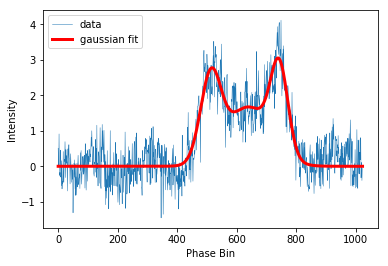

In [36]:
plot_fit(x,y,fit,params,sigma)

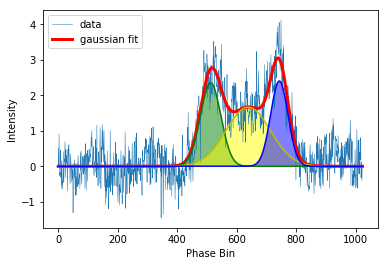

In [37]:
plot_fill(x,y,params)

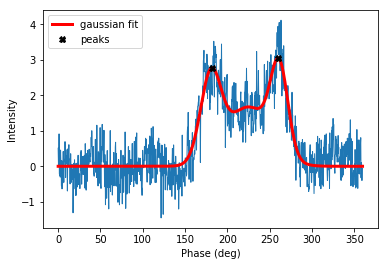

In [38]:
plot_peaks(x*(360/1024),y,profile_comp)

In [39]:
profile_comp

pulse_component(frequency=484.93150684931504, comp1=component(phase=181.7578125, intensity=2.7785764111146305), comp2=component(phase=259.8046875, intensity=3.0551324919759235), errors=[1.9753490033776822, 2.396136154113333, 0.2217399135556661, 1.9753490033776822, 2.396136154113333, 0.2217399135556661])

#### For the EPTA data set

In [40]:
phase=highfrequencyprofile['phase']
intensity=highfrequencyprofile['intensity']
x = phase
y=[]

In [41]:
m=statistics.mean(intensity[600:])

In [42]:
for i in intensity:
    y.append(i-m)

In [43]:
#Taken from Peaks and Gaussian fittings of frequency band 73
expected=(270,30,25,370,80,20,470,20,20)

In [44]:
params,sigma = fitting_parameters(x,y,expected)
fit = gauss_fit(x, params)
profile_comp = gauss_peaks_epta(params,fit,no_freq_bands,freqband,sigma)

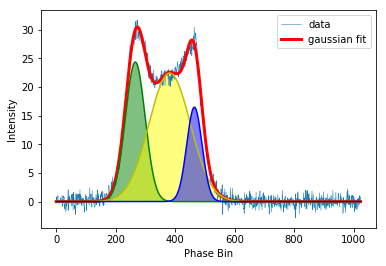

In [45]:
plot_fill(x,y,params)

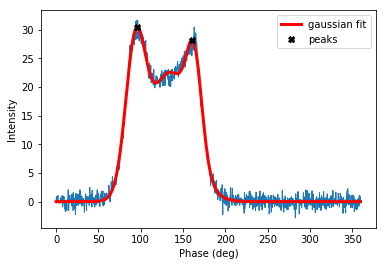

In [46]:
plot_peaks(x*(360/1024),y,profile_comp)

#### MWA Data Set

In [47]:
phase=mwaprofile['phase']
intensity=mwaprofile['intensity']
x = phase
y=[]


In [48]:
m=statistics.mean(intensity[10:30])

In [49]:
for i in intensity:
    y.append(i-m)

In [50]:
expected=(37,7,2*10**7,46,5,0.3*10**7,56,5,3.6*10**7)

In [51]:
params,sigma = fitting_parameters(x,y,expected)
fit = gauss_fit(x, params)
profile_comp = gauss_peaks_mwa(params, fit,no_freq_bands,freqband,sigma)

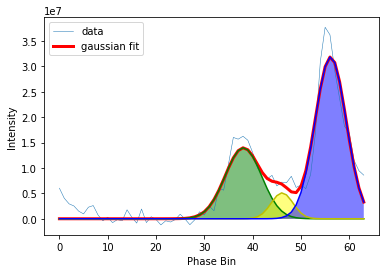

In [52]:
plot_fill(x,y,params)

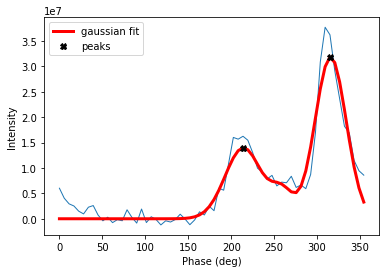

In [53]:
plot_peaks(x*(360/64),y,profile_comp)

# Gaussian Plotting and Finding Peaks of Overall Fit Data (fit_components) and Individual Fit Data (ind_components)


The following is a looped version of the previous section to find the correct peaks for each pulse profile

In [54]:
fit_components = []
ind_components= []

In [55]:
#Taken from Peaks and Gaussian fittings of frequency band 73, in the middle
expected=(501,30,8.02,655,80,4.07,741,20,11.29)

for i in range(0,no_freq_bands):
    freqband = i
  
  #Can be used for error checking
  #print(freqband)

    f = averageprofiles['frequency'] == freqband

    x=averageprofiles['phase'][f]
    y=averageprofiles['intensity'][f]

    if len(x)!=0 and len(y)!=0:
        params,sigma = fitting_parameters(x,y,expected)
        fit = gauss_fit(x, params)
        profile_comp = gauss_peaks_gmrt(params, fit, no_freq_bands, freqband, sigma)
        profile_ind = ind_peaks(params, no_freq_bands, freqband, sigma)

    #Can be used for error checking
    #print(profile_comp)
  
        fit_components.append(profile_comp)
        ind_components.append(profile_ind)

In [56]:
expected=(270,30,25,370,80,20,470,20,20)

phase=highfrequencyprofile['phase']
intensity=highfrequencyprofile['intensity']
x = phase
y=[]

m=statistics.mean(intensity[600:])

for i in intensity:
    y.append(i-m)

if len(x)!=0 and len(y)!=0:
    params,sigma = fitting_parameters(x,y,expected)
    fit = gauss_fit(x, params)
    profile_compsh = gauss_peaks_epta(params,fit, no_freq_bands, freqband, sigma)

    #Can be used for error checking
    #print(profile_comp)

In [57]:
#Taken from Peaks and Gaussian fittings of frequency band 73, in the middle
expected=(37,7,2*10**7,46,5,0.3*10**7,56,5,3.6*10**7)

phase=mwaprofile['phase']
intensity=mwaprofile['intensity']
x = phase
y=[]

m=statistics.mean(intensity[10:30])

for i in intensity:
    y.append(i-m)

if len(x)!=0 and len(y)!=0:
    params,sigma = fitting_parameters(x,y,expected)
    fit = gauss_fit(x, params)
    profile_compm = gauss_peaks_mwa(params, fit,no_freq_bands,freqband,sigma)

    #Can be used for error checking
    #print(profile_comp)

# Change of Peak Position over Frequency

## Fit Peaks (fit_components)

Starting to graph out all the movement of component phase across frequency

---



In [58]:
phase_comp1=[]
frequency_comp1=[]
comp1_err=[]

for i in range(0,len(fit_components)):
    if fit_components[i][1][0] != 0:
        phase_comp1.append(fit_components[i][1][0])
        frequency_comp1.append(fit_components[i][0])
        comp1_err.append(fit_components[i][3][0])

Text(0,0.5,'Frequency')

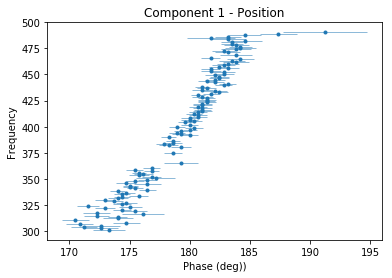

In [59]:
#py.plot(frequency_comp1,phase_comp1, '.')
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, label='data')
py.title('Component 1 - Position')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')

In [60]:
frequency_comp1, phase_comp1, comp1_err = detect_outlier(frequency_comp1, phase_comp1, comp1_err)

Text(0,0.5,'Frequency')

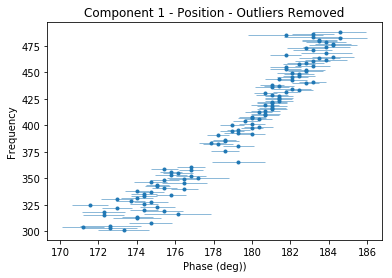

In [61]:
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, label='data')
py.title('Component 1 - Position - Outliers Removed')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')

In [62]:
expect=(500,0.4,16)
comp1_params,comp1_cov=curve_fit(thorsett,frequency_comp1,phase_comp1, expect, maxfev=10000, sigma=comp1_err, bounds=([0,-1,0],[1000,0.5,np.inf]))
comp1_fit_error=np.sqrt(np.diag(comp1_cov))
comp1_fit = thorsett(frequency_comp1, *comp1_params)

Text(0.5,0,'Frequency')

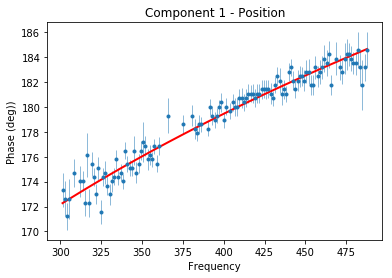

In [63]:
py.errorbar(frequency_comp1, phase_comp1, yerr=comp1_err, fmt='.', lw=0.5, label='data')
py.plot(frequency_comp1,comp1_fit, color='red',lw=2,label='thorsett fit')
py.title('Component 1 - Position')
py.ylabel('Phase (deg))')
py.xlabel('Frequency')

In [64]:
phase_comp2=[]
frequency_comp2=[]
comp2_err=[]

for i in range(0,len(fit_components)):
    if fit_components[i][2][0] != 0:
        phase_comp2.append(fit_components[i][2][0])
        frequency_comp2.append(fit_components[i][0])
        comp2_err.append(fit_components[i][3][3])

Text(0,0.5,'Frequency')

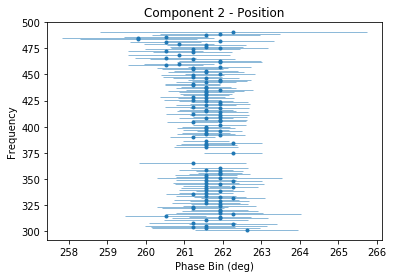

In [65]:
#py.plot(phase_comp2,frequency_comp2, '.')
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, label='data')
py.title('Component 2 - Position')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

In [66]:
frequency_comp2, phase_comp2, comp2_err = detect_outlier(frequency_comp2, phase_comp2, comp2_err)

Text(0,0.5,'Frequency')

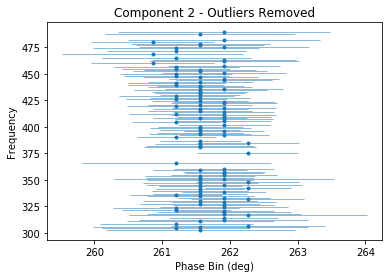

In [67]:
#py.plot(phase_comp2,frequency_comp2, '.')
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, label='data')
py.title('Component 2 - Outliers Removed')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

In [68]:
expect=(700,0.4,16)
comp2_params,comp2_cov=curve_fit(thorsett,frequency_comp2,phase_comp2, expect, maxfev=10000, sigma=comp2_err, bounds=([0,-1,0],[1000,0.5,np.inf]))
comp2_fit_error=np.sqrt(np.diag(comp2_cov))
comp2_fit = thorsett(frequency_comp2, *comp2_params)

Text(0.5,0,'Frequency')

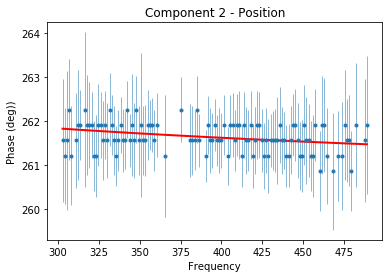

In [69]:
py.errorbar(frequency_comp2, phase_comp2, yerr=comp2_err, fmt='.', lw=0.5, label='data')
py.plot(frequency_comp2,comp2_fit, color='red',lw=2,label='thorsett fit')
py.title('Component 2 - Position')
py.ylabel('Phase (deg))')
py.xlabel('Frequency')

## Individual Peaks (ind_components)

In [70]:
phase_ind1=[]
frequency_ind1=[]

for i in range(0,len(ind_components)):
    if ind_components[i][1][0] != 0:
        phase_ind1.append(ind_components[i][1][0])
        frequency_ind1.append(ind_components[i][0])

Text(0,0.5,'Frequency')

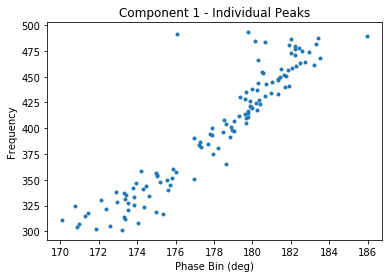

In [71]:
py.plot(phase_ind1,frequency_ind1, '.')
py.title('Component 1 - Individual Peaks')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

In [72]:
phase_ind2=[]
frequency_ind2=[]

for i in range(0,len(ind_components)):
  if ind_components[i][2][0] != 0:
    phase_ind2.append(ind_components[i][2][0])
    frequency_ind2.append(ind_components[i][0])

Text(0,0.5,'Frequency')

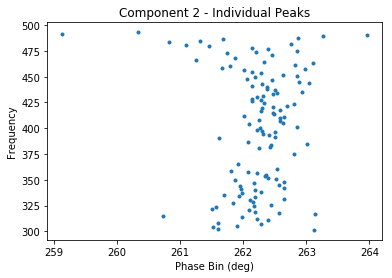

In [73]:
py.plot(phase_ind2,frequency_ind2, '.')
py.title('Component 2 - Individual Peaks')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

# Component Separation Across Frequency 

## Fit Peaks (fit_components)

## Individual Peaks (ind_components)

In [74]:
component_sep_ind, ind_sep_errors= separation_singleprofile(ind_components)

In [75]:
comp_sep_ind=[]
frequency_forsep_ind=[]

#range(0,no_freq_bands)
for i in range(0,len(component_sep_ind)):
  comp_sep_ind.append(component_sep_ind[i][1])
  frequency_forsep_ind.append(component_sep_ind[i][0])

Text(0,0.5,'Δθ (deg)')

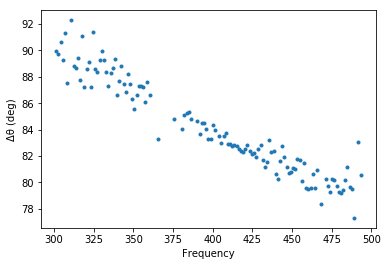

In [76]:
py.plot(frequency_forsep_ind, comp_sep_ind, '.')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

# Fitting Power Laws to Separation 

## Fit Peaks (fit_components) - Just GMRT

In [77]:
component_sep, sep_error = separation_singleprofile(fit_components)

In [78]:
comp_sep=[]
frequency_forsep=[]

#range(0,no_freq_bands)
for i in range(0,len(component_sep)):
  comp_sep.append(component_sep[i][1])
  frequency_forsep.append(component_sep[i][0])

Text(0,0.5,'Δθ (deg)')

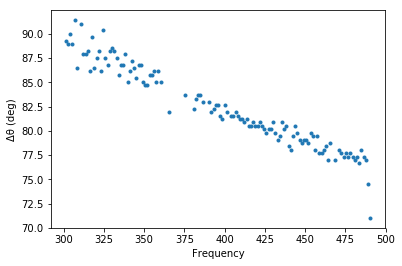

In [79]:
py.plot(frequency_forsep, comp_sep, '.')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [80]:
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))
separation_fit=thorsett(frequency_forsep,*sep_params)

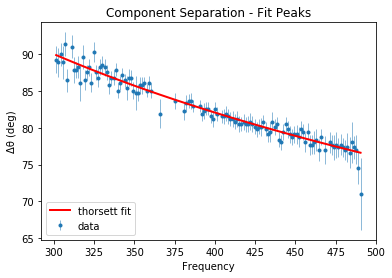

In [81]:
#py.plot(frequency_forsep, comp_sep, '.', label='data')
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data',zorder=1)
py.plot(frequency_forsep,separation_fit, color='red',lw=2,label='thorsett fit',zorder=2)
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower left')


In [82]:
#chi, p = sp.stats.chisquare(comp_sep, separation_fit)
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
#print('The chi squared value for the fit is: ', chi)
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')

The equation of fit for this pulsar is: 	 Δθ = 461.832 ν^-0.123 + -139.563 

The errors are 360.050, 0.353, 641.347 
Units for Δθ is degrees and ν is MHz


## Fit Peaks (fit_components) - GMRT/MWA/EPTA

In [83]:
fit_components.insert(0,profile_compsh)
fit_components.append(profile_compm)

In [84]:
profile_compm

pulse_component(frequency=185, comp1=component(phase=213.75, intensity=13971824.856107147), comp2=component(phase=315.0, intensity=31846535.938114986), errors=[0.7692129016487452, 0.7315358193031422, 1290564.8329481627, 0.7692129016487452, 0.7315358193031422, 1290564.8329481627])

In [85]:
component_sep, sep_error = separation_singleprofile(fit_components)

In [86]:
sep_error[-1]

1.087831317864017

In [87]:
comp_sep=[]
frequency_forsep=[]

#range(0,no_freq_bands)
for i in range(0,len(component_sep)):
    comp_sep.append(component_sep[i][1])
    frequency_forsep.append(component_sep[i][0])

In [88]:
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))

In [89]:
sepa_fit=[]
x_sepa_fit=list(range(150,1400))
for i in x_sepa_fit:
    sepa_fit.append(sep_params[0]*(i**(sep_params[1]))+sep_params[2])

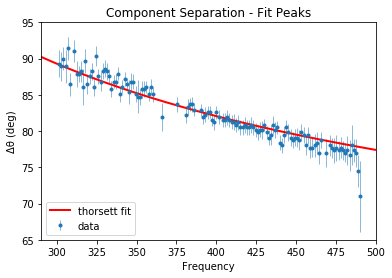

In [90]:
#py.plot(frequency_forsep, comp_sep, '.', label='data')
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data')
py.plot(x_sepa_fit,sepa_fit, color='red',lw=2,label='thorsett fit')
py.axis((290,500,65,95))
#py.axis((100,1500,60,105))
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower left')

In [91]:
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')

The equation of fit for this pulsar is: 	 Δθ = 2318.815 ν^-0.717 + 50.551 

The errors are 555.595, 0.050, 2.026 
Units for Δθ is degrees and ν is MHz


## Individual Peaks (ind_components)

In [92]:
#To use in weightings: sigma=inv_var_ind
inv_var_ind = []

for i in range(len(ind_sep_errors)):
  temp = 1/(ind_sep_errors[i]*ind_sep_errors[i])
  inv_var_ind.append(temp)

In [93]:
expect=(200,0.5,50)
sep_params_ind,sep_cov_ind=curve_fit(thorsett,frequency_forsep_ind,comp_sep_ind, expect, maxfev=1000000,sigma=inv_var_ind,bounds=([0,-1,0],[1000,0.5,np.inf]))
sep_fit_error_ind=np.sqrt(np.diag(sep_cov_ind))

In [94]:
print(sep_params_ind)
separation_fit_ind = thorsett(frequency_forsep, *sep_params_ind)

[ 1.00000000e+03 -6.31140391e-01  6.19484055e+01]


ValueError: x and y must have same first dimension, but have shapes (122,) and (123,)

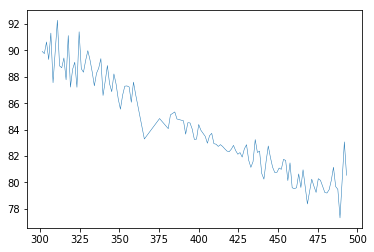

In [95]:
py.plot(frequency_forsep_ind, comp_sep_ind, lw=0.5, label='data')
py.plot(frequency_forsep_ind,separation_fit_ind, color='red',lw=1,label='power fit')
py.title('Component Separation - Individual Peaks ')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [ ]:
chi_ind, p_ind = sp.stats.chisquare(comp_sep, separation_fit)
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params_ind[0]:.3f} \u03BD^{sep_params_ind[1]:.3f} + {sep_params_ind[2]:.3f} \n')
print(f'The errors are {sep_fit_error_ind[0]:.3f}, {sep_fit_error_ind[1]:.3f}, {sep_fit_error_ind[2]:.3f} ')
print('The chi squared value for the fit is: ', chi_ind)
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')

# Change in Intensity over Frequency

## Fit Peaks (fit_components)

In [ ]:
intensity_comp1=[]
frequency_comp1=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp1.append(fit_components[i][1][1])
    frequency_comp1.append(fit_components[i][0])

In [ ]:
py.plot(frequency_comp1,intensity_comp1, '.')
py.title('Component 1 - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('Intensity')

In [ ]:
intensity_comp2=[]
frequency_comp2=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp2.append(fit_components[i][2][1])
    frequency_comp2.append(fit_components[i][0])

In [ ]:
py.plot(frequency_comp2,intensity_comp2, '.')
py.title('Component 2 - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('Intensity')

## Individual Peaks (ind_components)

In [ ]:
intensity_ind1=[]
frequency_ind1=[]

for i in range(0,len(ind_components)):
  if ind_components[i][1][0] != 0:
    intensity_ind1.append(ind_components[i][1][1])
    frequency_ind1.append(ind_components[i][0])

In [ ]:
py.plot(frequency_ind1,intensity_ind1, '.')
py.title('Component 1 - Individual Peaks')
py.xlabel('Frequency')
py.ylabel('Intensity')

In [ ]:
intensity_ind2=[]
frequency_ind2=[]

for i in range(0,len(ind_components)):
  if ind_components[i][1][0] != 0:
    intensity_ind2.append(ind_components[i][2][1])
    frequency_ind2.append(ind_components[i][0])

In [ ]:
py.plot(frequency_ind2,intensity_ind2, '.')
py.title('Component 2 - Individual Peaks')
py.xlabel('Frequency')
py.ylabel('Intensity')

# Intensity Fitting

In [ ]:
int1_params,int1_cov=curve_fit(thorsett,frequency_ind1,intensity_ind1, maxfev=10000)
int1_error=np.sqrt(np.diag(int1_cov))

In [ ]:
int1_fit = thorsett(frequency_ind1, *int1_params)

In [ ]:
py.plot(frequency_ind1, intensity_ind1, lw=0.5, label='data')
py.plot(frequency_ind1, int1_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [ ]:
int2_params,int2_cov=curve_fit(thorsett,frequency_ind2,intensity_ind2, maxfev=10000)
int2_error=np.sqrt(np.diag(int2_cov))

In [ ]:
int2_fit = thorsett(frequency_ind2, *int2_params)

In [ ]:
py.plot(frequency_ind2, intensity_ind2, lw=0.5, label='data')
py.plot(frequency_ind2, int1_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

# Change in Width over Frequency

In [ ]:
width_ind1=[]
frequency_ind1=[]

for i in range(0,len(ind_components)):
  if ind_components[i][1][0] != 0:
    width_ind1.append(ind_components[i][1][2])
    frequency_ind1.append(ind_components[i][0])

In [ ]:
py.plot(frequency_ind1,width_ind1, '.')
py.title('Component 1 - Individual Peaks')
py.xlabel('Frequency')
py.ylabel('Width (deg)')

In [ ]:
width_ind2=[]
frequency_ind2=[]

for i in range(0,len(ind_components)):
  if ind_components[i][1][0] != 0:
    width_ind2.append(ind_components[i][2][2])
    frequency_ind2.append(ind_components[i][0])

In [ ]:
py.plot(frequency_ind2,width_ind2, '.')
py.title('Component 2 - Individual Peaks')
py.xlabel('Frequency')
py.ylabel('Width (deg)')

# Width Fitting

In [ ]:
wid1_params,wid1_cov=curve_fit(thorsett,frequency_ind1,width_ind1, maxfev=10000)
wid1_error=np.sqrt(np.diag(wid1_cov))

In [ ]:
wid1_fit = thorsett(frequency_ind1, *wid1_params)

In [ ]:
py.plot(frequency_ind1, width_ind1, lw=0.5, label='data')
py.plot(frequency_ind1,wid1_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [ ]:
wid2_params,wid2_cov=curve_fit(thorsett,frequency_ind2,width_ind2, maxfev=10000)
wid2_error=np.sqrt(np.diag(wid2_cov))

In [ ]:
wid2_fit = thorsett(frequency_ind2, *wid2_params)

In [ ]:
py.plot(frequency_ind2, width_ind2, lw=0.5, label='data')
py.plot(frequency_ind2, wid2_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')